# Identifying relationships between annotated omics data in NMDC

This notebook is an example of how different omics data types may be linked via commonly used annotation vocabularies and investigated together. In this notebook we explore biomolecules and KEGG pathways identified in a set of samples that have processed metagenomics, metaproteomics, and metabolomics data available in the NMDC Data Portal.

In [2]:
# Setup 
# Add renv project library to R environment variable libPaths()
.libPaths(c(.libPaths(), "../../renv/library/*/R-*/*"))

# Load required packages
suppressPackageStartupMessages({
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(readr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(purrr)
library(tibble)
library(jsonlite)
library(KEGGREST)
library(circlize)
library(pathview)
})

# Load NMDC API functions from this repo
if(Sys.getenv("COLAB_BACKEND_VERSION") == "") source("../../utility_functions.R")

if(Sys.getenv("COLAB_BACKEND_VERSION") != "") source("http://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/utility_functions.R")

## 1. Retrieve data from the NMDC database using API endpoints

### Choose data to retrieve

The NMDC data portal (https://data.microbiomedata.org/) allows us to filter data and samples according to many criteria. In this case, we use the Data Type filters (the upset plot under the interactive map widget) to identify samples that have metagenomics, metaproteomics, and metabolomics data. This returns 33 samples from the study "Riverbed sediment microbial communities from the Columbia River, Washington, USA" (https://data.microbiomedata.org/details/study/nmdc:sty-11-aygzgv51).

### Retrieve and filter data for Columbia River sediment study

The study page linked above has the NMDC study identifier in the URL: `nmdc:sty-11-aygzgv51`. We will use the function `get_data_objects_for_study` (defined in `utility_functions.R`) to retrieve all records that represent data. This includes URLs for downloading raw data files (e.g. FASTQ or mass spectra files) as well as processed data results output by the NMDC workflows.


In [3]:
# Retrieve all data objects associated with this study
dobj <- get_data_objects_for_study("nmdc:sty-11-aygzgv51")

One way of further identifying a NMDC `DataObject` record is by looking at its slot `data_object_type` (https://microbiomedata.github.io/nmdc-schema/data_object_type/), which contains a value from `FileTypeEnum` (https://microbiomedata.github.io/nmdc-schema/FileTypeEnum/). 

We want to look at the processed data results for our three omics types of interest in this notebook. Specifically, we want the files containing KEGG Orthology, KEGG Compound, and Enzyme Commission annotations. These annotations are available in separate files for the metagenomics data (in 'Annotation Enzyme Commission' and 'Annotation KEGG Orthology' data objects) and are found together in the metabolomics ('GC-Metabolomics Results') and metaproteomics ('Protein Report') results files.

We filter for results files with the following `data_object_type` values:

| Value | Description |
|:-----:|:-----------:|
|Annotation Enzyme Commission|Tab delimited file for EC annotation|
|Annotation KEGG Orthology|Tab delimited file for KO annotation|
|GC-MS Metabolomics Results|GC-MS-based metabolite assignment results table|
|Protein Report|Filtered protein report file|

In [4]:
dobj <- dobj %>%
  # Filter to biosamples with metagenome EC annotations, metagenome KO 
  # annotations, metaproteomics results, and metabolomics results
  group_by(biosample_id) %>%
  filter("Annotation Enzyme Commission" %in% data_object_type &
           "Annotation KEGG Orthology" %in% data_object_type & 
           "GC-MS Metabolomics Results" %in% data_object_type &
           "Protein Report" %in% data_object_type) %>%
  ungroup() %>%
  
  # Remove uninformative columns for simpler dataframe
  select(-c(alternative_identifiers, in_manifest, was_generated_by))

### Download selected results files
 
Now we can use the `url` slot from the filtered `DataObject` records to read in all of the files containing the annotations of interest.

In [5]:
results_by_biosample <- dobj %>%
  
  # Filter to desired results file types and create one URL column per type
  filter(data_object_type %in% c("Annotation Enzyme Commission", "Annotation KEGG Orthology",
                                 "GC-MS Metabolomics Results", "Protein Report")) %>%
  select(biosample_id, data_object_type, url) %>%
  pivot_wider(names_from = data_object_type, values_from = url) %>%
  
  # Read in the TSV/CSV results files
  # Add in column names from the IMG genome download README
  mutate(metag_ec_results = lapply(
    .$`Annotation Enzyme Commission`, 
    function(x) { 
      d <- read_tsv(x, col_names = FALSE, show_col_types = FALSE)
      names(d) <- c("gene_id", "img_ko_flag", "EC", "percent_identity",
                    "query_start", "query_end", "subj_start", "subj_end",
                    "evalue", "bit_score", "align_length")
      d
      })) %>%
  
  mutate(metag_ko_results = lapply(
    .$`Annotation KEGG Orthology`, 
    function(x) { 
      d <- read_tsv(x, col_names = FALSE, show_col_types = FALSE)
      names(d) <- c("gene_id", "img_ko_flag", "ko_term", "percent_identity",
                    "query_start", "query_end", "subj_start", "subj_end",
                    "evalue", "bit_score", "align_length")
      d
      })) %>%

  mutate(metap_results = lapply(.$`Protein Report`, read_tsv, col_names = TRUE, show_col_types = FALSE)) %>%
  mutate(metab_results = lapply(.$`GC-MS Metabolomics Results`, read_csv, col_names = TRUE, show_col_types = FALSE))

Each of the downloaded data files contains detailed information including the KO, EC, or KEGG Compound identifiers.

In [6]:
# View a snippet of the metagenome KEGG Orthology annotations file
head(results_by_biosample$metag_ko_results[[1]])

gene_id,img_ko_flag,ko_term,percent_identity,query_start,query_end,subj_start,subj_end,evalue,bit_score,align_length
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
nmdc:wfmgan-11-z0q72297.1_000001_7_501,2999021309,KO:K09129,96.95,1,164,1,164,1.2e-113,370,164
nmdc:wfmgan-11-z0q72297.1_000001_822_2396,2999016232,KO:K08482,57.28,1,522,17,536,1.4e-211,685,522
nmdc:wfmgan-11-z0q72297.1_000001_2919_3773,2999016149,KO:K07652,45.16,15,267,512,790,1.8e-71,260,253
nmdc:wfmgan-11-z0q72297.1_000001_8181_8969,2999039711,KO:K07238,80.84,2,262,32,291,5.4e-144,466,261
nmdc:wfmgan-11-z0q72297.1_000002_2920_3669,2999021898,KO:K07090,80.97,3,249,1,247,6.7e-141,456,247
nmdc:wfmgan-11-z0q72297.1_000002_5075_5563,2999019508,KO:K04750,75.64,3,158,2,157,9.2e-84,284,156


### Extract unique identifications

From each results table we can extract the unique list of genes/proteins/metabolites identified in that sample.

We also create a vector for each biomolecule containing all unique identifications across all samples, to simplify API calls later. 

In [7]:
# Small wrapper function for commonly used function pair in this notebook
unlist_unique <- function (x) {
  unique(unlist(x, use.names = FALSE))
}


# Metagenome annotations - KEGG Orthology
# Save a unique vector of gene KO by sample
metag_ko_unique_list <- results_by_biosample$metag_ko_results %>%
  lapply(FUN = function(x) { sort(unique(x$ko_term)) }) %>%
  setNames(results_by_biosample$biosample_id)

# Save a unique vector of ALL gene KO for searching later
metag_ko_unique <- unlist_unique(metag_ko_unique_list)

# Metagenome annotations - Enzyme Commission
# Save a unique vector of gene EC by sample
metag_ec_unique_list <- results_by_biosample$metag_ec_results %>%
  lapply(FUN = function(x) { sort(unique(x$EC)) }) %>%
  setNames(results_by_biosample$biosample_id)

# Save a unique vector of ALL gene EC for searching later
metag_ko_unique <- unlist_unique(metag_ec_unique_list)


# Metaproteome annotations - KEGG Orthology
# Protein KO by sample
metap_ko_unique_list <- results_by_biosample$metap_results %>%
  lapply(FUN = function(x) { sort(unique(x$KO)) }) %>%
  setNames(results_by_biosample$biosample_id)

# ALL protein KO
metap_ko_unique <- unlist_unique(metap_ko_unique_list)

# Metaproteome annotations - Enzyme Commission
# Protein EC by sample
metap_ec_unique_list <- results_by_biosample$metap_results %>%
  # Protein report may have multiple EC annotations per line
  lapply(FUN = function(x) { x$EC_Number %>% strsplit(",") %>% unlist_unique() %>% sort() }) %>%
  setNames(results_by_biosample$biosample_id)

# ALL protein EC
metap_ec_unique <- unlist_unique(metap_ec_unique_list)

# Dataframe of metaproteome annotations across all samples
# Keep KO and EC results together
metap_combined_unique <- results_by_biosample$metap_results %>%
  bind_rows() %>%
  select(KO, EC_Number) %>%
  rename(ec_id = "EC_Number",
         ko_id = "KO") %>%
  # EC column may have multiple comma separated values
  # Reform dataframe to have one EC per row
  separate_wider_delim(ec_id, delim = ",", names_sep = ".", too_few = "align_start") %>%
  pivot_longer(cols = starts_with("ec_id"), names_to = NULL, values_to = "ec_id") %>%
  filter(if_any(everything(), ~ !is.na(.))) %>%
  # Filter out excess NA rows from pivot
  group_by(ko_id) %>%
  mutate(has_value = any(!is.na(ec_id))) %>%
  ungroup() %>%
  filter(!(has_value & is.na(ec_id))) %>%
  select(-has_value) %>%
  distinct()


# Metabolome annotations - KEGG Compound
# Compound IDs per sample
metab_co_unique_list <- results_by_biosample$metab_results %>%
  lapply(FUN = function(x) { sort(unique(x$`Kegg Compound ID`)) }) %>%
  setNames(results_by_biosample$biosample_id)

# ALL compound IDs
metab_co_unique <- unlist_unique(metab_co_unique_list)

## 2. Use annotations in file output to link identifications

Metagenomic and metaproteomic results in NMDC already have both KEGG Orthology and Enzyme Commission annotations which can be used to link gene and protein identifications without any additional information from KEGG. 

The plot below is a simple example of how to start associating the gene/protein results by counting the number of metagenomic KO annotations that also appear in the metaproteomic results.

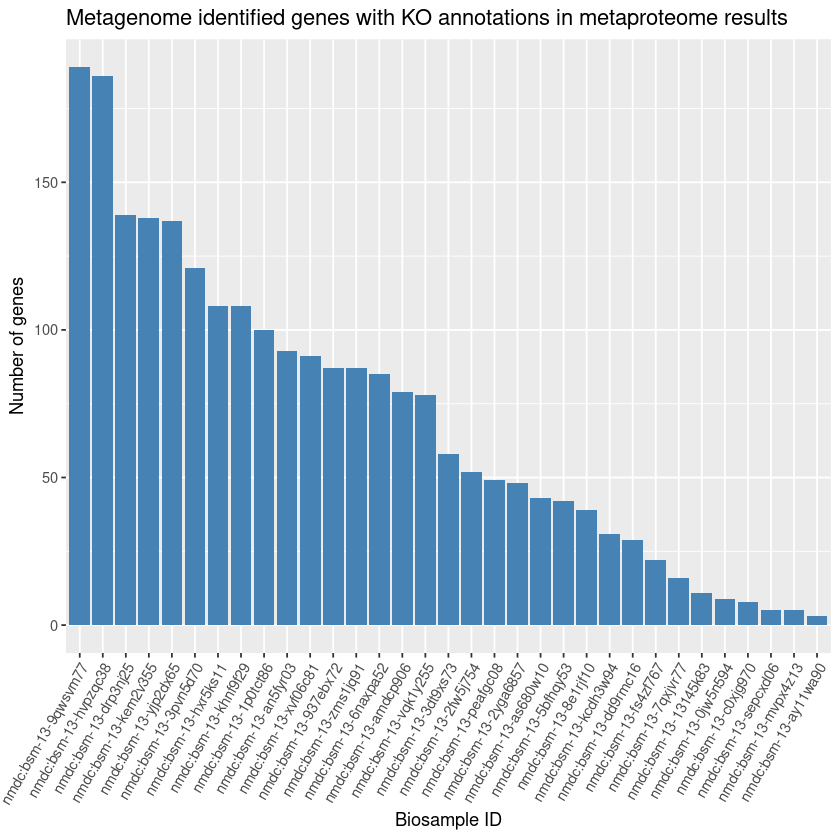

In [14]:
# For each sample, check which metagenomic KO results also appear in the metaproteomic KO results
map2(.x = metag_ko_unique_list, .y = metap_ko_unique_list, 
     .f = ~if_else((.x %in% .y), "Has_Protein", "No_Protein")) %>%
  stack() %>%
  dplyr::rename(biosample_id = "ind", result = "values") %>%
  group_by(biosample_id, result) %>%
  summarize(count = n(), .groups = "drop_last") %>%
  ungroup() %>%
  filter(result == "Has_Protein") %>%
  arrange(-count) %>%
  mutate(biosample_id = factor(biosample_id, levels = biosample_id)) %>%

  # Plot the number of identified genes that have a corresponding protein identification by sample
  ggplot() +
    geom_bar(aes(x = biosample_id, y = count), stat = "identity", fill = "steelblue") +
    ggtitle("Metagenome identified genes with KO annotations in metaproteome results") +
    xlab("Biosample ID") + 
    ylab("Number of genes") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1),
          legend.position = "none")

The rest of this notebook uses the KEGG API to retrieve additional information for identified biomolecules, which enables more multi-omic analysis and provides more context for their biological relevance. Use of the KEGG API is restricted to academic users or commercial license holders (see [Licensing Information](##-Licensing-Information)).

## 3. Get IDs from other KEGG databases

Now we will use the KEGGREST package (available on Bioconductor) to make calls to the KEGG API. Using the annotations provided in the NMDC results files, we can look up their corresponding annotations in KEGG databases to start drawing connections between biomolecule identifications. 

For example, in the first use of `KEGGREST::keggLink()` below, we are searching the KEGG ENZYME database for Enzyme Commission numbers that are _linked_ to each KEGG Compound ID in the character vector `metab_co_unique`.

We will also search for linked KEGG modules and pathways. KEGG pathways are manually drawn maps that represent all the reactions in a biological process and are typically composed of a number of more discrete functional units, the KEGG modules.

Notes:
- `keggLink()` calls are paired with a 0.5s `Sys.sleep()` command. This is to limit the number of API calls we are making per second to avoid overloading the KEGG REST API and having API calls rejected.
- Character vectors of IDs to query are broken up into 50-element pieces to avoid overly long HTTP request URLs.

### Gather metabolite information

First we will find all of the Enzyme Commission numbers available for each identified compound. These EC numbers represent enzymes that catalyze reactions involving the compound of interest.

In [44]:
# Get all EC ids for each compound
ec_from_metabolites <- metab_co_unique %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { Sys.sleep(0.5); keggLink("enzyme", x) }) %>%
  list_c()
  
# Format into a nested dataframe
ec_from_metabolites <- data.frame(compound_id = names(ec_from_metabolites),
                                  ec_id = ec_from_metabolites) %>%
  nest(.by = compound_id, .key = "ec_id")

Then we will do the same to pull all of the modules and pathways that each compound is a part of. 

In [45]:
# Get all module ids for each compound
modules_from_metabolites <- metab_co_unique %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { Sys.sleep(0.5); keggLink("module", x) }) %>%
  list_c()
  
# Format into a nested dataframe
modules_from_metabolites <- data.frame(compound_id = names(modules_from_metabolites),
                                       module_id = modules_from_metabolites) %>%
  nest(.by = compound_id, .key = "module_id")


# Get all pathway ids for each compound
pathways_from_metabolites <- metab_co_unique %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { Sys.sleep(0.5); keggLink("pathway", x) }) %>%
  list_c()
  
# Format into a nested dataframe
pathways_from_metabolites <- data.frame(compound_id = names(pathways_from_metabolites),
                                        pathway_id = pathways_from_metabolites) %>%
  nest(.by = compound_id, .key = "pathway_id")

Join the results to produce a dataframe containing EC, module, and pathway IDs for each metabolite identified across all samples.

In [46]:
# Assemble
metabolite_annotations <- data.frame(compound_id = paste0("cpd:", metab_co_unique),
                                     compound_trimmed = metab_co_unique) %>%
  left_join(ec_from_metabolites, by = join_by(compound_id)) %>%
  left_join(modules_from_metabolites, by = join_by(compound_id)) %>%
  left_join(pathways_from_metabolites, by = join_by(compound_id))

head(metabolite_annotations, 3)

,compound_id,compound_trimmed,ec_id,module_id,pathway_id
,<chr>,<chr>,<list>,<list>,<list>
1,cpd:C00009,C00009,"c(""ec:1.....","c(""md:M0....","c(""path:...."
2,cpd:C00016,C00016,"c(""ec:1.....","c(""md:M0....","c(""path:...."
3,cpd:C00020,C00020,"c(""ec:1.....","c(""md:M0....","c(""path:...."


Finally, use a filtering join on the list of metabolite identifications per biosample and the list of all metabolite annotations to create a list of dataframes containing all annotations per biosample.

In [47]:
# Pre-allocate an empty list for metabolite dataframes
metabolite_annotations_list <- vector(mode = "list", length = nrow(results_by_biosample))

for (biosample in 1:nrow(results_by_biosample)) {
  
  # For each sample, assemble a dataframe of metabolite information
  # Start with the unique list of metabolites for this sample
  metabolite_annotations_list[[biosample]] <- data.frame(compound_id = paste0("cpd:", metab_co_unique_list[[biosample]])) %>%
    # Filter join all metabolite annotations down to just the ones in this sample
    left_join(metabolite_annotations, by = join_by(compound_id))
}

names(metabolite_annotations_list) <- names(metab_co_unique_list)

# Cleanup intermediate objects
rm(metabolite_annotations, ec_from_metabolites, modules_from_metabolites, pathways_from_metabolites, metab_co_unique, metab_co_unique_list)

head(metabolite_annotations_list[[1]], 3)

,compound_id,compound_trimmed,ec_id,module_id,pathway_id
,<chr>,<chr>,<list>,<list>,<list>
1,cpd:C00009,C00009,"c(""ec:1.....","c(""md:M0....","c(""path:...."
2,cpd:C00016,C00016,"c(""ec:1.....","c(""md:M0....","c(""path:...."
3,cpd:C00020,C00020,"c(""ec:1.....","c(""md:M0....","c(""path:...."


### Gather protein information

Next we will do the same thing for proteins in each sample - starting with the KO and EC IDs from the NMDC annotation workflow, identify the modules and pathways each protein is associated with, and what corresponding metabolites/genes were identified in this sample.

In [48]:
# Use concatenated proteins vector, make all the calls once, then split up by biosample

# Get all module ids for each protein
modules_from_proteins <- metap_ko_unique %>%
  substring(4) %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { Sys.sleep(0.5); keggLink("module", x) }) %>%
  list_c()
  
# Format into a nested dataframe
modules_from_proteins <- data.frame(ko_id = toupper(names(modules_from_proteins)),
                                    module_id = modules_from_proteins) %>%
  nest(.by = ko_id, .key = "module_id")


# Get all pathway ids for each protein
pathways_from_proteins <- metap_ko_unique %>%
  substring(4) %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { Sys.sleep(0.5); keggLink("pathway", x) }) %>%
  list_c()
  
# Format into a nested dataframe
pathways_from_proteins <- data.frame(ko_id = toupper(names(pathways_from_proteins)),
                                     pathway_id = pathways_from_proteins) %>%
  nest(.by = ko_id, .key = "pathway_id")


# Assemble, starting from the dataframe of joined KO/EC annotations from the Protein Report
protein_annotations <- metap_combined_unique %>%
  left_join(modules_from_proteins, by = join_by(ko_id)) %>%
  left_join(pathways_from_proteins, by = join_by(ko_id))


# Pre-allocate an empty list for protein dataframes
protein_annotations_list <- vector(mode = "list", length = nrow(results_by_biosample))

for (biosample in 1:nrow(results_by_biosample)) {
  
  # For each sample, assemble a dataframe of protein information
  # Start with the unique list of proteins for this sample
  protein_annotations_list[[biosample]] <- data.frame(ko_id = metap_ko_unique_list[[biosample]]) %>%
    # Filter join all metabolite annotations down to just the ones in this sample
    left_join(protein_annotations, by = join_by(ko_id))
}

names(protein_annotations_list) <- names(metap_ko_unique_list)

# Cleanup intermediate objects
rm(protein_annotations, modules_from_proteins, pathways_from_proteins, metap_ec_unique_list, metap_ko_unique_list, metap_combined_unique, metap_ec_unique, metap_ko_unique)

head(protein_annotations_list[[1]])

,ko_id,ec_id,module_id,pathway_id
,<chr>,<chr>,<list>,<list>
1,KO:K00024,EC:1.1.1.37,"c(""md:M0....","c(""path:...."
2,KO:K00368,EC:1.7.2.1,"c(""md:M0....","c(""path:...."
3,KO:K00371,EC:1.7.5.1,"c(""md:M0....","c(""path:...."
4,KO:K00371,EC:1.7.99.-,"c(""md:M0....","c(""path:...."
5,KO:K01053,EC:3.1.1.17,md:M00129,"c(""path:...."
6,KO:K01342,EC:3.4.21.62,,


### Gather gene information

Finally we will find modules and pathways for each gene and create the same list of dataframes for the metagenomes in each sample.

In [49]:
# Use concatenated metag KO vector, make all the calls once, then split up by biosample

# Get all module ids for each gene
modules_from_genes <- metag_ko_unique %>%
  # API doesn't like the prefix in the annotated results, trim it off
  # eg. KO:K12345 becomes K12345
  substring(4) %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { Sys.sleep(0.5); keggLink("module", x) }) %>%
  list_c()
  
# Format into a nested dataframe
modules_from_genes <- data.frame(ko_id = toupper(names(modules_from_genes)),
                                 module_id = modules_from_genes) %>%
  nest(.by = ko_id, .key = "module_id")


# Get all pathway ids for each gene
pathways_from_genes <- metag_ko_unique %>%
  substring(4) %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { Sys.sleep(0.5); keggLink("pathway", x) }) %>%
  list_c()
  
# Format into a nested dataframe
pathways_from_genes <- data.frame(ko_id = toupper(names(pathways_from_genes)),
                                  pathway_id = pathways_from_genes) %>%
  nest(.by = ko_id, .key = "pathway_id")


# Assemble
gene_annotations <- data.frame(ko_id = metag_ko_unique) %>%
  left_join(modules_from_genes, by = join_by(ko_id)) %>%
  left_join(pathways_from_genes, by = join_by(ko_id))

The metagenome results have KO and EC IDs in different annotation files, as we saw above when reading in results files. Join the EC IDs to the KO IDs here.

There is a filter applied in this step to only retain genes that have EC IDs. This is because there are more gene identifications than there are proteins and metabolites, and for this notebook we want to focus on the genes that could potentially be linked to proteins or metabolites by their EC ID. This affects downstream pathway coverage counts.

In [50]:
# Pre-allocate an empty list for gene dataframes
gene_annotations_list <- vector(mode = "list", length = nrow(results_by_biosample))

for (biosample in 1:nrow(results_by_biosample)) {
  
  # Add in the EC annotations here - it will be easier since they are in a separate file per sample
  
  # For each sample, assemble a dataframe of gene information

  # Start by pairing the KO and EC information from the annotation results files
  gene_annotations_list[[biosample]] <- results_by_biosample$metag_ko_results[[biosample]] %>%
    full_join(results_by_biosample$metag_ec_results[[biosample]],
              # Join by NMDC metag workflow assigned gene ID
              by = join_by(gene_id)) %>%
    select(ko_term, EC) %>%
    distinct() %>%
    rename(ko_id = "ko_term",
           ec_id = "EC") %>%
    
    # Filter to only KO identifications that also have EC information
    filter(!is.na(ec_id)) %>%
    
    # Now filter join all gene annotations down to just the ones in this sample
    left_join(gene_annotations, by = join_by(ko_id))
}

names(gene_annotations_list) <- names(metag_ko_unique_list)

# Cleanup intermediate objects
rm(gene_annotations, modules_from_genes, pathways_from_genes, metag_ko_unique, metag_ko_unique_list)

Warning message in full_join(., results_by_biosample$metag_ec_results[[biosample]], :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 7 of `x` matches multiple rows in `y`.
ℹ Row 33960 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


### Identify linked IDs between biosamples

We can now check which biosamples have linked annotations for other types of biomolecules. The code below iterates through samples and adds two columns in each annotation dataframe labelling whether that molecule has a linked annotation among the other two omics types for that sample.

In [51]:
# Add "is this x in y" columns for all biomolecules

for (biosample in 1:nrow(results_by_biosample)) {
  
  metabolite_annotations_list[[biosample]] <- metabolite_annotations_list[[biosample]] %>%
    
    # The EC ID column in metabolite annotations is actually a list of character vectors,
    # since each compound (row) can have multiple EC annotations
    mutate(In_Metag_Annotations = vapply(.$ec_id, function(x) { any(x$ec_id %in% tolower(gene_annotations_list[[biosample]]$ec_id)) }, FUN.VALUE = TRUE),
           In_Prot_Annotations = vapply(.$ec_id, function(x) { any(x$ec_id %in% tolower(protein_annotations_list[[biosample]]$ec_id)) }, FUN.VALUE = TRUE))
  

  protein_annotations_list[[biosample]] <- protein_annotations_list[[biosample]] %>% 
    # tolower() is needed because the KEGG output has lowercase prefixes
    mutate(In_Metab_Annotations = tolower(ec_id) %in% unlist_unique(metabolite_annotations_list[[biosample]]$ec_id),
           In_Metag_Annotations = ko_id %in% gene_annotations_list[[biosample]]$ko_id)
  
  
  gene_annotations_list[[biosample]] <- gene_annotations_list[[biosample]] %>%
    mutate(In_Metab_Annotations = tolower(ec_id) %in% unlist_unique(metabolite_annotations_list[[biosample]]$ec_id),
           In_Prot_Annotations = ko_id %in% protein_annotations_list[[biosample]]$ko_id)
}

## 4. Visualize shared biomolecule identifications

The `circlize` package enables construction of circular diagrams with arcs between sectors showing relationships between multiple groups. We will use `circlize` to create a chord diagram showing where the annotations from the metagenomic, metaproteomic, and metabolomic results link to each other. 

First, choose a biosample from the list to visualize. Then use its gathered annotations to calculate the sectors and arcs needed for the plot. There will be three sectors representing genes, proteins, and metabolites, then three arcs connecting the pairs of sectors.

In [52]:
# Select an example biosample
example_gene <- gene_annotations_list[[2]]
example_prot <- protein_annotations_list[[2]]
example_metab <- metabolite_annotations_list[[2]]

# Scale sectors so that arc widths are proportional rather than absolute for better visualization
largest_sector_xlim <- max(length(example_gene$ko_id),
                           length(example_prot$ko_id),
                           length(example_metab$compound_id))

# Gene sector
# Calculate size of sector
gene_sector_xlim <- (length(example_gene$ko_id))

# Sum the number of genes that show up in the protein annotations, then scale
gene_sector_prot_count <- (sum(example_gene$In_Prot_Annotations)) * (largest_sector_xlim / gene_sector_xlim)
# Sum the number of genes that show up in protein AND metabolite annotations, then scale
gene_sector_both_count <- (nrow(filter(example_gene, In_Metab_Annotations & In_Prot_Annotations))) * (largest_sector_xlim / gene_sector_xlim)
# Sum the number of genes that show up in metabolite annotations, then scale
gene_sector_metab_count <-(sum(example_gene$In_Metab_Annotations)) * (largest_sector_xlim / gene_sector_xlim)

# Prot sector
prot_sector_xlim <- length(example_prot$ko_id)

prot_sector_metab_count <- sum(example_prot$In_Metab_Annotations) * (largest_sector_xlim / prot_sector_xlim)
prot_sector_both_count <- nrow(filter(example_prot, In_Metab_Annotations & In_Metag_Annotations)) * (largest_sector_xlim / prot_sector_xlim)
prot_sector_gene_count <-sum(example_prot$In_Metag_Annotations) * (largest_sector_xlim / prot_sector_xlim)


# Metab sector
metab_sector_xlim <- length(example_metab$compound_id)

metab_sector_gene_count <- sum(example_metab$In_Metag_Annotations) * (metab_sector_xlim / prot_sector_xlim)
metab_sector_both_count <- nrow(filter(example_metab, In_Metag_Annotations & In_Prot_Annotations)) * (metab_sector_xlim / prot_sector_xlim)
metab_sector_prot_count <-sum(example_metab$In_Prot_Annotations) * (metab_sector_xlim / prot_sector_xlim)

# Reset sector sizes to scaled value
gene_sector_xlim <- largest_sector_xlim
prot_sector_xlim <- largest_sector_xlim
metab_sector_xlim <- largest_sector_xlim

Now use the calculated sectors/arcs to generate the chord diagram.

Note: The first link end is drawn out of sector 'genes'.

Note: The second link end is drawn out of sector 'proteins'.

Note: The first link end is drawn out of sector 'proteins'.

Note: The first link end is drawn out of sector 'metabolites'.



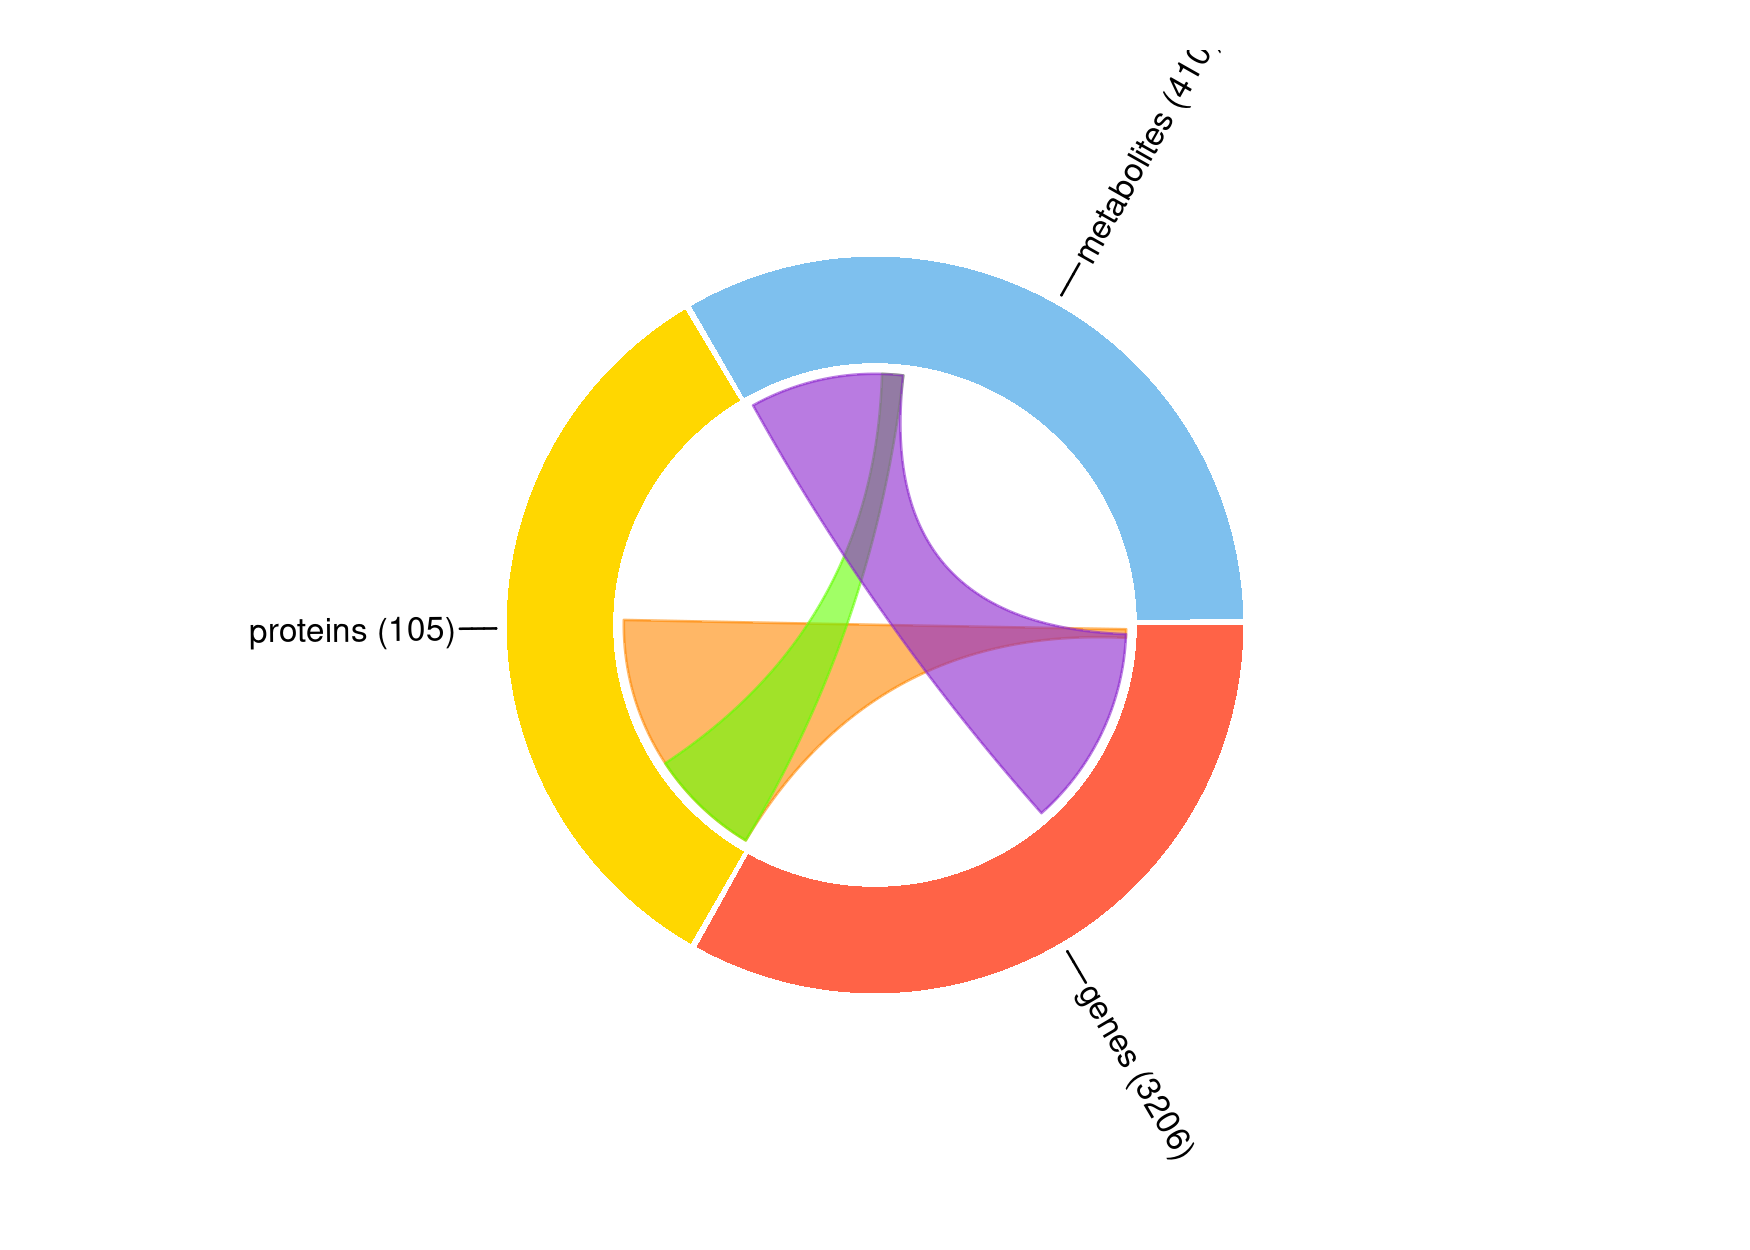

In [53]:
plot_sector_names <- c("genes", "proteins", "metabolites")
 
# Assemble data
data = data.frame(
    sectors = c(rep("genes", gene_sector_xlim),
               rep("proteins", prot_sector_xlim),
               rep("metabolites", metab_sector_xlim)),
    x = c(seq(1:gene_sector_xlim),
          seq(1:prot_sector_xlim),
          seq(1:metab_sector_xlim)),
    y = c(seq(1:gene_sector_xlim),
          seq(1:prot_sector_xlim),
          seq(1:metab_sector_xlim))) %>%
  mutate(sectors = factor(sectors, levels = plot_sector_names))
 
# Initialize the plot with the three specified sectors
circos.initialize(factors = data$sectors, x = data$x)

circos.labels(plot_sector_names, 
              x = c(gene_sector_xlim/2, prot_sector_xlim/2, metab_sector_xlim/2), 
              labels = c(paste0("genes (", nrow(example_gene), ")"),
                         paste0("proteins (", nrow(example_prot), ")"), 
                         paste0("metabolites (", nrow(example_metab), ")")),
              side = "outside")

 
# Build and color the three sectors in the outermost ring
circos.trackPlotRegion(factors = data$sectors, y=data$y, bg.col = c("tomato", "gold", "skyblue2") , bg.border = NA)
 
# Add links (aka arcs or chords) between sectors
# From the gene sector to the protein sector
circos.link(
      # Create a link that starts at the beginning of the gene sector
      # It is as wide as the scaled number of gene/protein shared annotations (see above)
      "genes", c(0, gene_sector_prot_count), 
      
      # The other end of the link is in the protein sector
      # It starts at the number of protein/metabolite but NOT gene shared annotations
      # It is as wide as the scaled number of gene/protein shared annotations
      "proteins", c(prot_sector_metab_count - prot_sector_both_count, 
                    prot_sector_metab_count - prot_sector_both_count + prot_sector_gene_count), 
      col = "#ff870099")

# Repeat for proteins/metab
circos.link("proteins", c(0, prot_sector_metab_count), 
            "metabolites", c(metab_sector_gene_count - metab_sector_both_count,
                             metab_sector_gene_count - metab_sector_both_count + metab_sector_prot_count), 
            col = "#63ff0099")


# Repeat for metab/genes
circos.link("metabolites", c(0, metab_sector_gene_count), 
            "genes", c(gene_sector_prot_count - gene_sector_both_count,
                       gene_sector_prot_count - gene_sector_both_count + gene_sector_metab_count), 
            col = "#8b24cd99")

In the chord diagram, each arc is showing what proportion of identified biomolecules have a linked annotation in the identified biomolecules on the other end of the arc. For example, the purple arc shows that about a third of the genes have a link to a compound ID that was identified in the metabolomics data for this sample. 

Areas where the ends of two arcs overlap (e.g., the green and orange arc ends at the bottom of the protein sector) indicate that those molecules have corresponding identified biomolecules in all three data types.

## 5. Calculate coverage of KEGG pathways across samples

Assemble a list of all of the pathway IDs that any biomolecules in each sample map to (obtained from API calls earlier).
The KEGG API returns duplicate IDs for each pathway, one that is blank, and one that has all of the KO elements highlighted. Exclude the highlighted maps from the list for redundancy.
Some of the maps are "overview" maps which encompass an enormous number of metabolic reactions, to the point that it is not especially informative if a compound maps to one. Exclude those pathways as well. (See https://www.genome.jp/kegg/pathway.html#global) 

In [54]:
pathways_by_biosample <- vector(mode = "list", length = nrow(results_by_biosample))

for (biosample in 1:length(pathways_by_biosample)) {

  # Get unique list of pathways from all identified biomolecules
  sample_pathways <- c(gene_annotations_list[[biosample]]$pathway_id, 
                       protein_annotations_list[[biosample]]$pathway_id,
                       metabolite_annotations_list[[biosample]]$pathway_id) %>%
    unlist(use.names = FALSE) %>%
    unique()
  
  # Look at basic pathway maps, exclude KO highlighted pathway maps
  sample_pathways <- sample_pathways[!str_detect(sample_pathways, "path:ko")]
  
  # Exclude "overview" pathway maps
  sample_pathways <- sample_pathways[!str_detect(sample_pathways, "path:map01")]
  
  pathways_by_biosample[[biosample]] <- sample_pathways
  
}

Now, using the complete list of pathways, make one more set of API calls to obtain the full list of compounds and KO elements found in that pathway. In this case we are only searching for KO and compound IDs, EC IDs in pathways just point to the corresponding KO element.

There is a filter applied in this step that retains pathways with at least one gene and at least one compound. Some KEGG pathways have all KO/EC elements or all compounds and in this notebook we want to examine pathways that have both.

In [55]:
# Concatenate the pathways, make all the calls once, then join to pathways_by_biosample

# Get all compounds for each pathway
compounds_from_pathways <- pathways_by_biosample %>%
  unlist(use.names = FALSE) %>%
  unique() %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { keggLink("compound", x) }) %>%
  list_c()
  
# Format into a nested dataframe
compounds_from_pathways <- data.frame(pathway_id = names(compounds_from_pathways),
                                      compound_id = compounds_from_pathways) %>%
  nest(.by = pathway_id, .key = "compound_id")


# Get all KO for each pathway
ko_from_pathways <- pathways_by_biosample %>%
  unlist(use.names = FALSE) %>%
  unique() %>%
  split(ceiling(seq_along(.)/50)) %>%
  lapply(FUN = function(x) { keggLink("ko", x) }) %>%
  list_c()

# Format into a nested dataframe
ko_from_pathways <- data.frame(pathway_id = names(ko_from_pathways),
                               ko_id = ko_from_pathways) %>%
  nest(.by = pathway_id, .key = "ko_id")


# Count the elements that comprise each pathway for calculations later
all_pathway_elements <- full_join(compounds_from_pathways, ko_from_pathways, 
                                  by = join_by(pathway_id)) %>%
  mutate(compound_count = vapply(compound_id, 
                                 FUN = function(x) { ifelse(is.null(x), 0, nrow(x)) }, 
                                 FUN.VALUE = 1)) %>%
  mutate(ko_count =       vapply(ko_id, 
                                 FUN = function(x) { ifelse(is.null(x), 0, nrow(x)) }, 
                                 FUN.VALUE = 1)) %>%
  mutate(total_elements = compound_count + ko_count) %>%
  # Filter to pathways with at least one of each
  filter(compound_count > 0 & ko_count > 0)

Now we will calculate the "coverage" of each KEGG pathway found in each biosample by simply dividing the number of biomolecules that were found in the omics data by the total number of elements in the pathway.

In [57]:
pathway_coverage_by_biosample <- vector(mode = "list", length = nrow(results_by_biosample))

for (biosample in 1:length(pathways_by_biosample)) {
  
  all_ko_detected <- unique(c(gene_annotations_list[[biosample]]$ko_id,
                              protein_annotations_list[[biosample]]$ko_id))
  
  pathway_coverage_by_biosample[[biosample]] <- all_pathway_elements %>%
    filter(pathway_id %in% pathways_by_biosample[[biosample]]) %>%
    mutate(compound_found    = vapply(.$compound_id, 
                                      function(x) { sum(x$compound_id %in% metabolite_annotations_list[[biosample]]$compound_id) }, 
                                      FUN.VALUE = 1),
           ko_found          = vapply(.$ko_id, 
                                      function(x) { sum(toupper(x$ko_id) %in% all_ko_detected) }, 
                                      FUN.VALUE = 1),
           compound_coverage = compound_found / compound_count,
           ko_coverage       = ko_found / ko_count,
           total_coverage    = (compound_found + ko_found)/total_elements) %>%
    
    select(-c(compound_id, ko_id)) %>%
    mutate_all(~ifelse(is.nan(.), NA, .)) %>%
    
    # Filter out pathways where we only found 1 element
    filter(compound_found + ko_found > 1) %>%
    arrange(-total_coverage)
}

names(pathway_coverage_by_biosample) <- names(gene_annotations_list)

## 6. Visualize KEGG pathway coverage across samples

### Pull biosample metadata

First, use the `get_results_by_id()` functions from `utility_functions.R` to retrieve selected metadata for the biosamples.

In [ ]:
# Pull biosample metadata and make sure samples are in the same order as data going into plots
ordered_metadata <- get_results_by_id(collection = "biosample_set",
                    match_id_field = "id",
                    id_list = results_by_biosample$biosample_id,
                    fields = "id,samp_name,description,depth.has_numeric_value,lat_lon") %>% 
                    unnest(cols = c(depth, lat_lon), names_sep = ".") %>%
                    right_join(data.frame(id = names(pathway_coverage_by_biosample)), by = join_by(id))


For this study, the samples were collected in two areas along the Columbia River. Create a vector of colors representing which area each sample was taken from to use in heatmaps.

In [ ]:
# Set up color vector for side grouping column
sample_color_vec <- case_when(
  str_detect(ordered_metadata$lat_lon.has_raw_value, "46\\.372") ~ "orange",
  str_detect(ordered_metadata$lat_lon.has_raw_value, "46\\.373") ~ "blue")

### Create pathway coverage heatmaps
 
In section 4 we created a list of dataframes containing the coverage of each pathway in each biosample.

We can visualize this as a heatmap, where the columns are KEGG pathways, the rows are biosamples, and the color gradient shows pathways with high/low coverage in each sample.

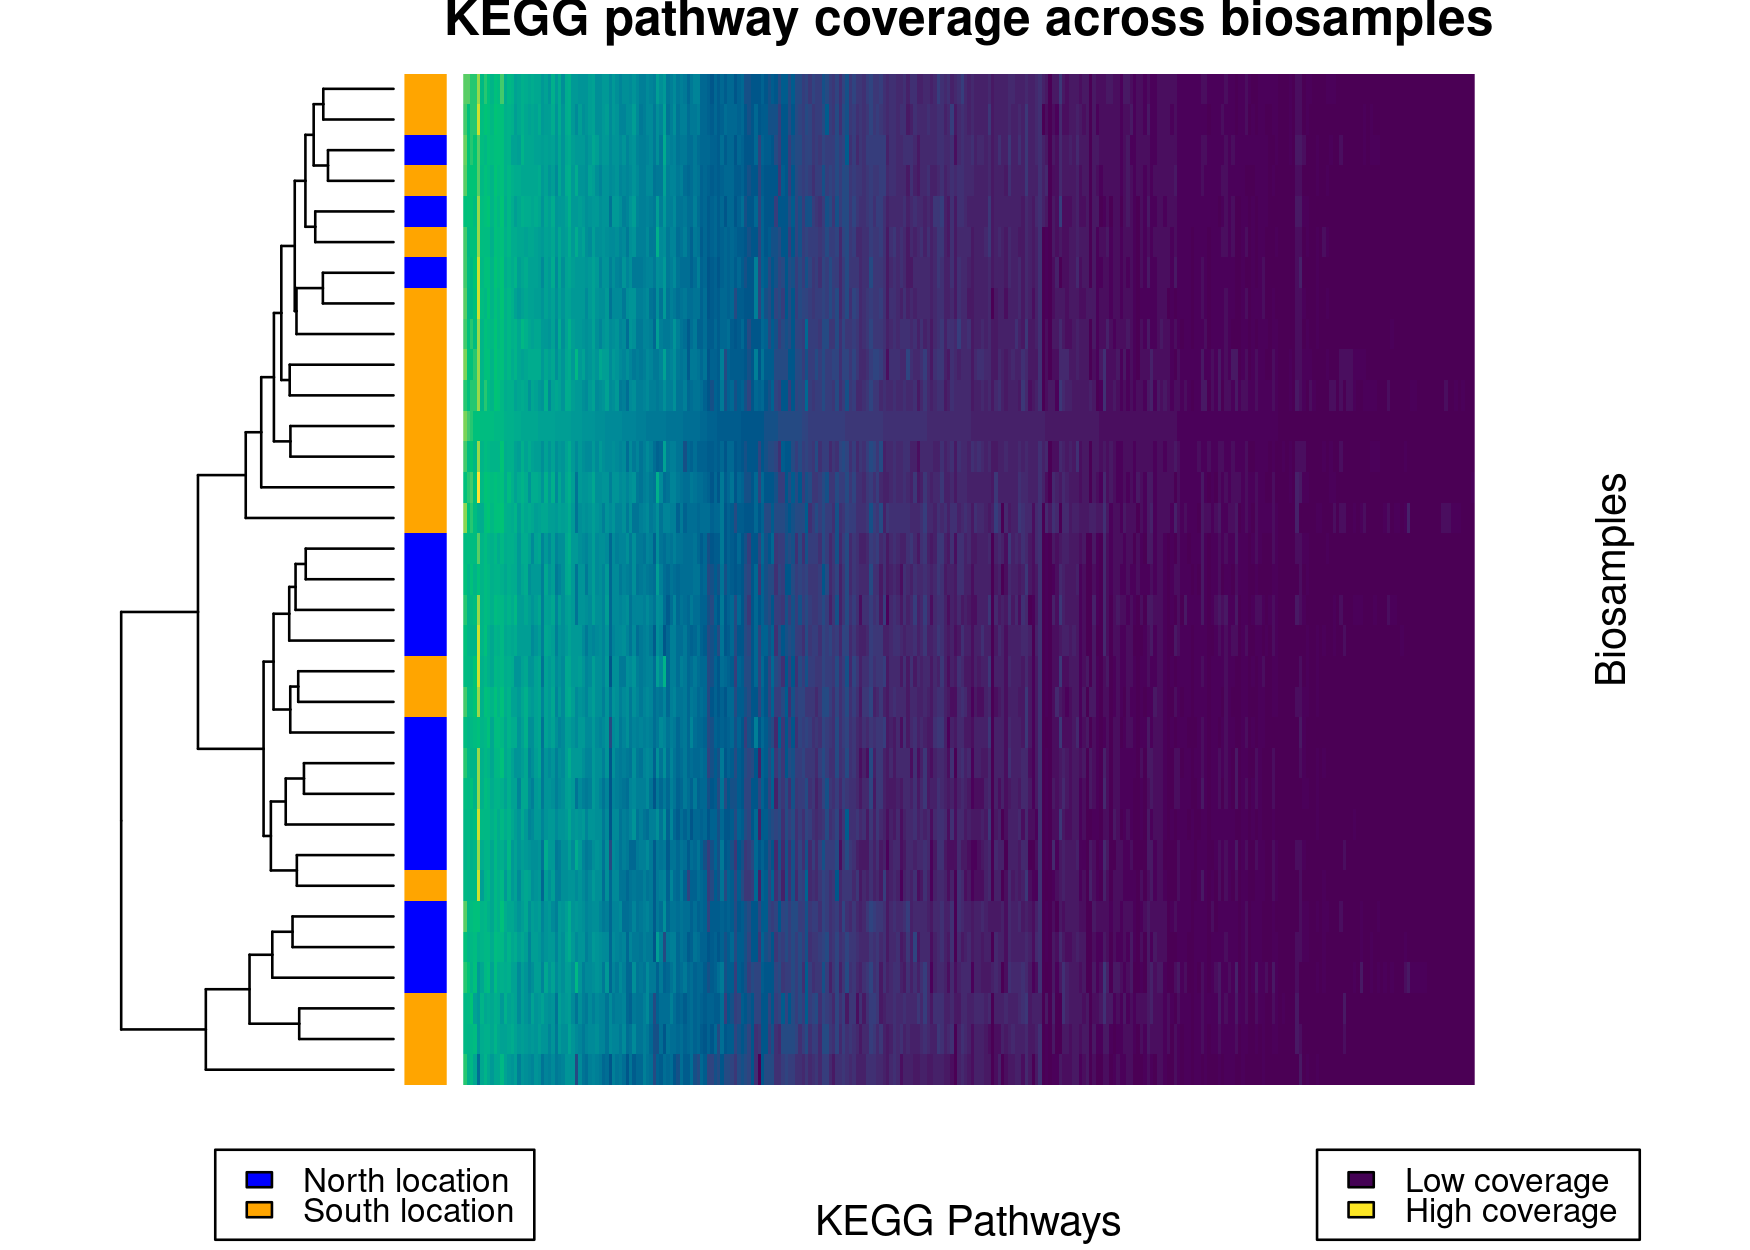

In [84]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 250)
par(xpd = TRUE)

pathway_coverage_by_biosample %>%
  bind_rows(.id = "biosample") %>%
  select(biosample, pathway_id, total_coverage) %>%
  pivot_wider(names_from = "pathway_id", values_from = "total_coverage") %>%
  replace(is.na(.), 0) %>%
  column_to_rownames(var = "biosample") %>%
  as.matrix() %>%
  
  heatmap(Colv = NA, RowSideColors = sample_color_vec,
          labRow = FALSE, labCol = FALSE, scale = "none",
          main = "KEGG pathway coverage across biosamples",
          xlab = "KEGG Pathways",
          ylab = "Biosamples", 
          keep.dendro = FALSE, na.rm= TRUE,
          col = hcl.colors(50))

par(cex = 0.8)

legend(x = "bottomright", legend = c("Low coverage", "High coverage"), fill = c("#440154", "#FDE725"), inset = c(0, -0.2))

legend(x = "bottomleft", legend = c("North location", "South location"), fill = c("blue", "orange"), inset = c(0, -0.2))

It does not appear that there is a huge difference in coverage between different groups of samples, samples largely share pathways where a higher proportion of KEGG orthologs and compounds were detected.

The pathway coverage dataframe also contains columns for `ko_coverage` and `compound_coverage`. Break the data down further and create a heatmap of just KO term coverage.

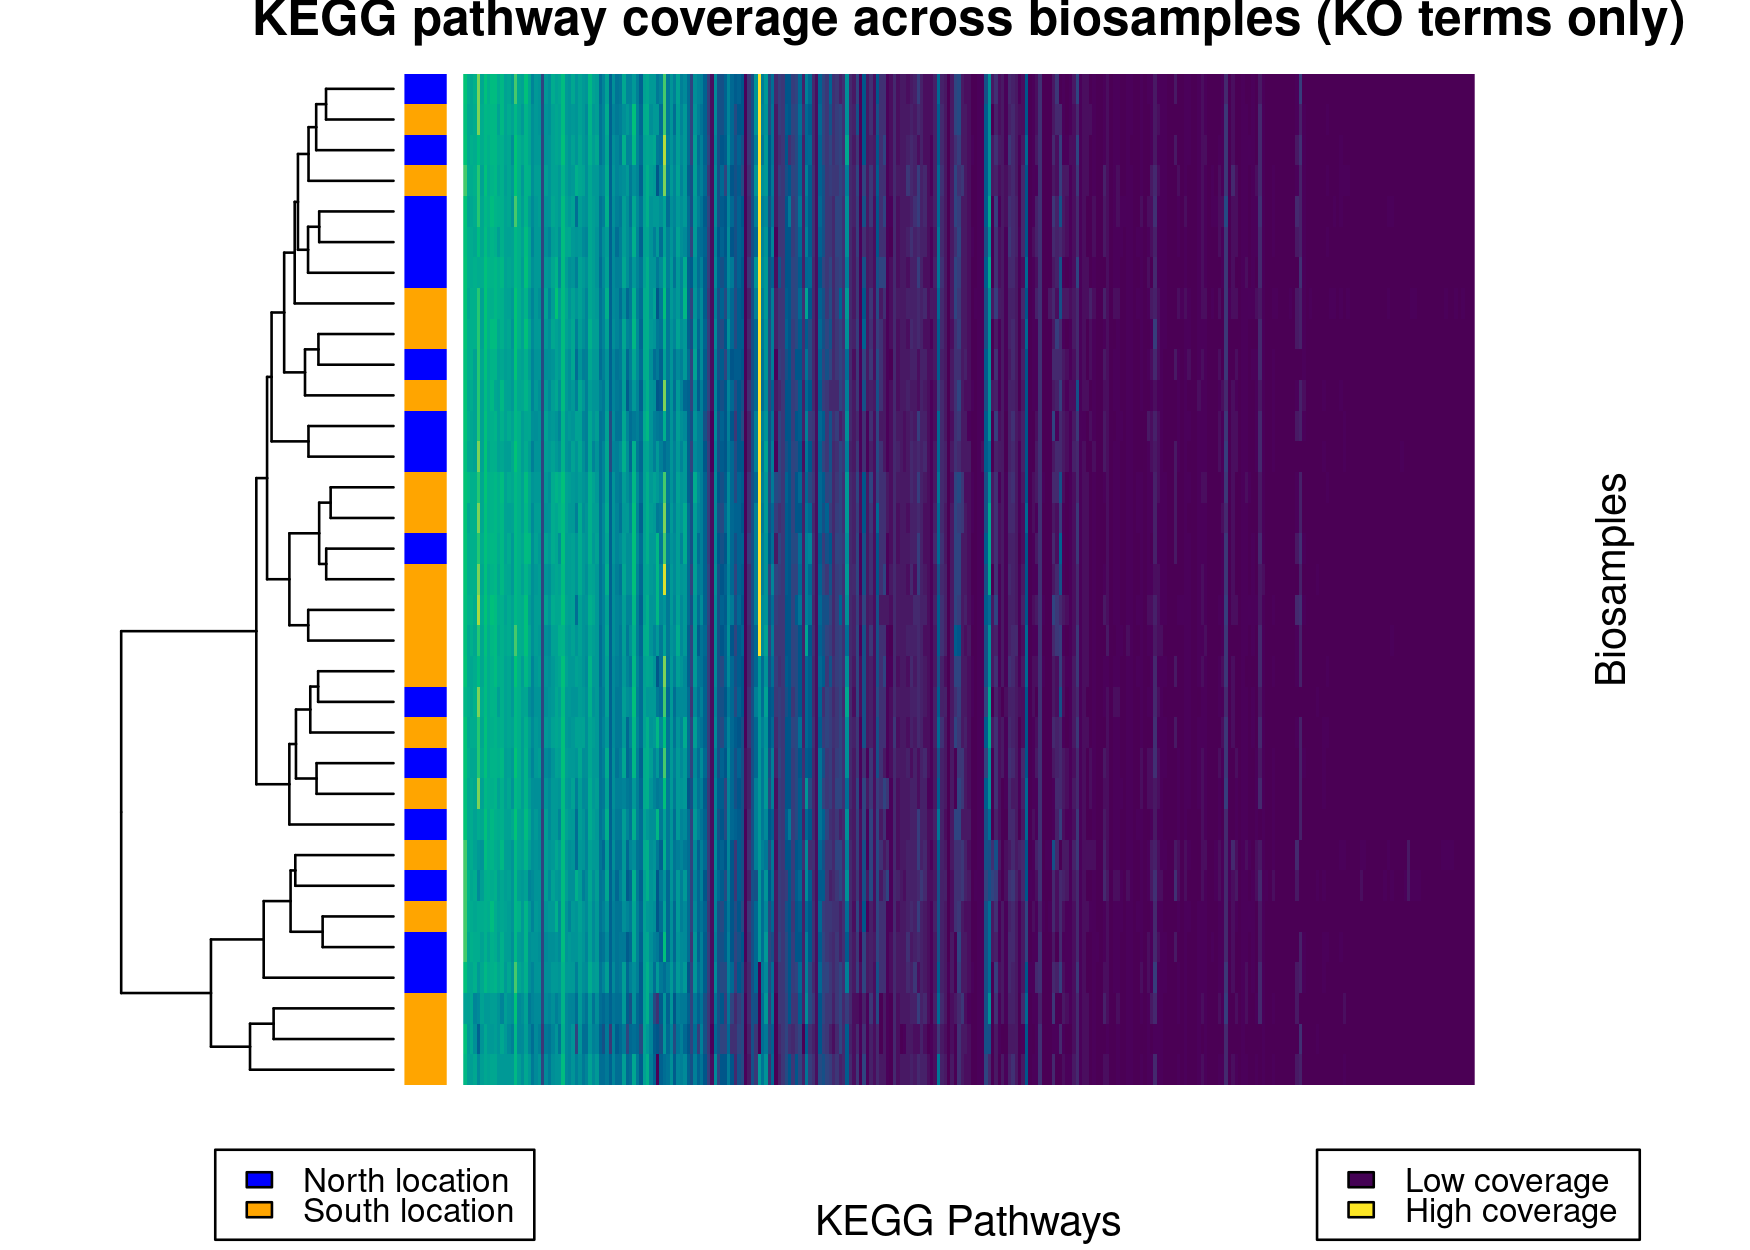

In [91]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 250)
par(xpd = TRUE)

pathway_coverage_by_biosample %>%
  bind_rows(.id = "biosample") %>%
  select(biosample, pathway_id, ko_coverage) %>%
  pivot_wider(names_from = "pathway_id", values_from = "ko_coverage") %>%
  replace(is.na(.), 0) %>%
  column_to_rownames(var = "biosample") %>%
  as.matrix() %>%
  
  heatmap(Colv = NA, RowSideColors = sample_color_vec,
          labRow = FALSE, labCol = FALSE, scale = "none",
          main = "KEGG pathway coverage across biosamples (KO terms only)",
          xlab = "KEGG Pathways",
          ylab = "Biosamples", 
          keep.dendro = FALSE, na.rm= TRUE,
          col = hcl.colors(50))

par(cex = 0.8)

legend(x = "bottomright", legend = c("Low coverage", "High coverage"), fill = c("#440154", "#FDE725"), inset = c(0, -0.2))

legend(x = "bottomleft", legend = c("North location", "South location"), fill = c("blue", "orange"), inset = c(0, -0.2))

The KO coverage heatmap has some features that stand out but also does not show much difference in coverage between the sample groups, seen by the lack of clustering on the sidebar.

Now look at only compound coverage values.

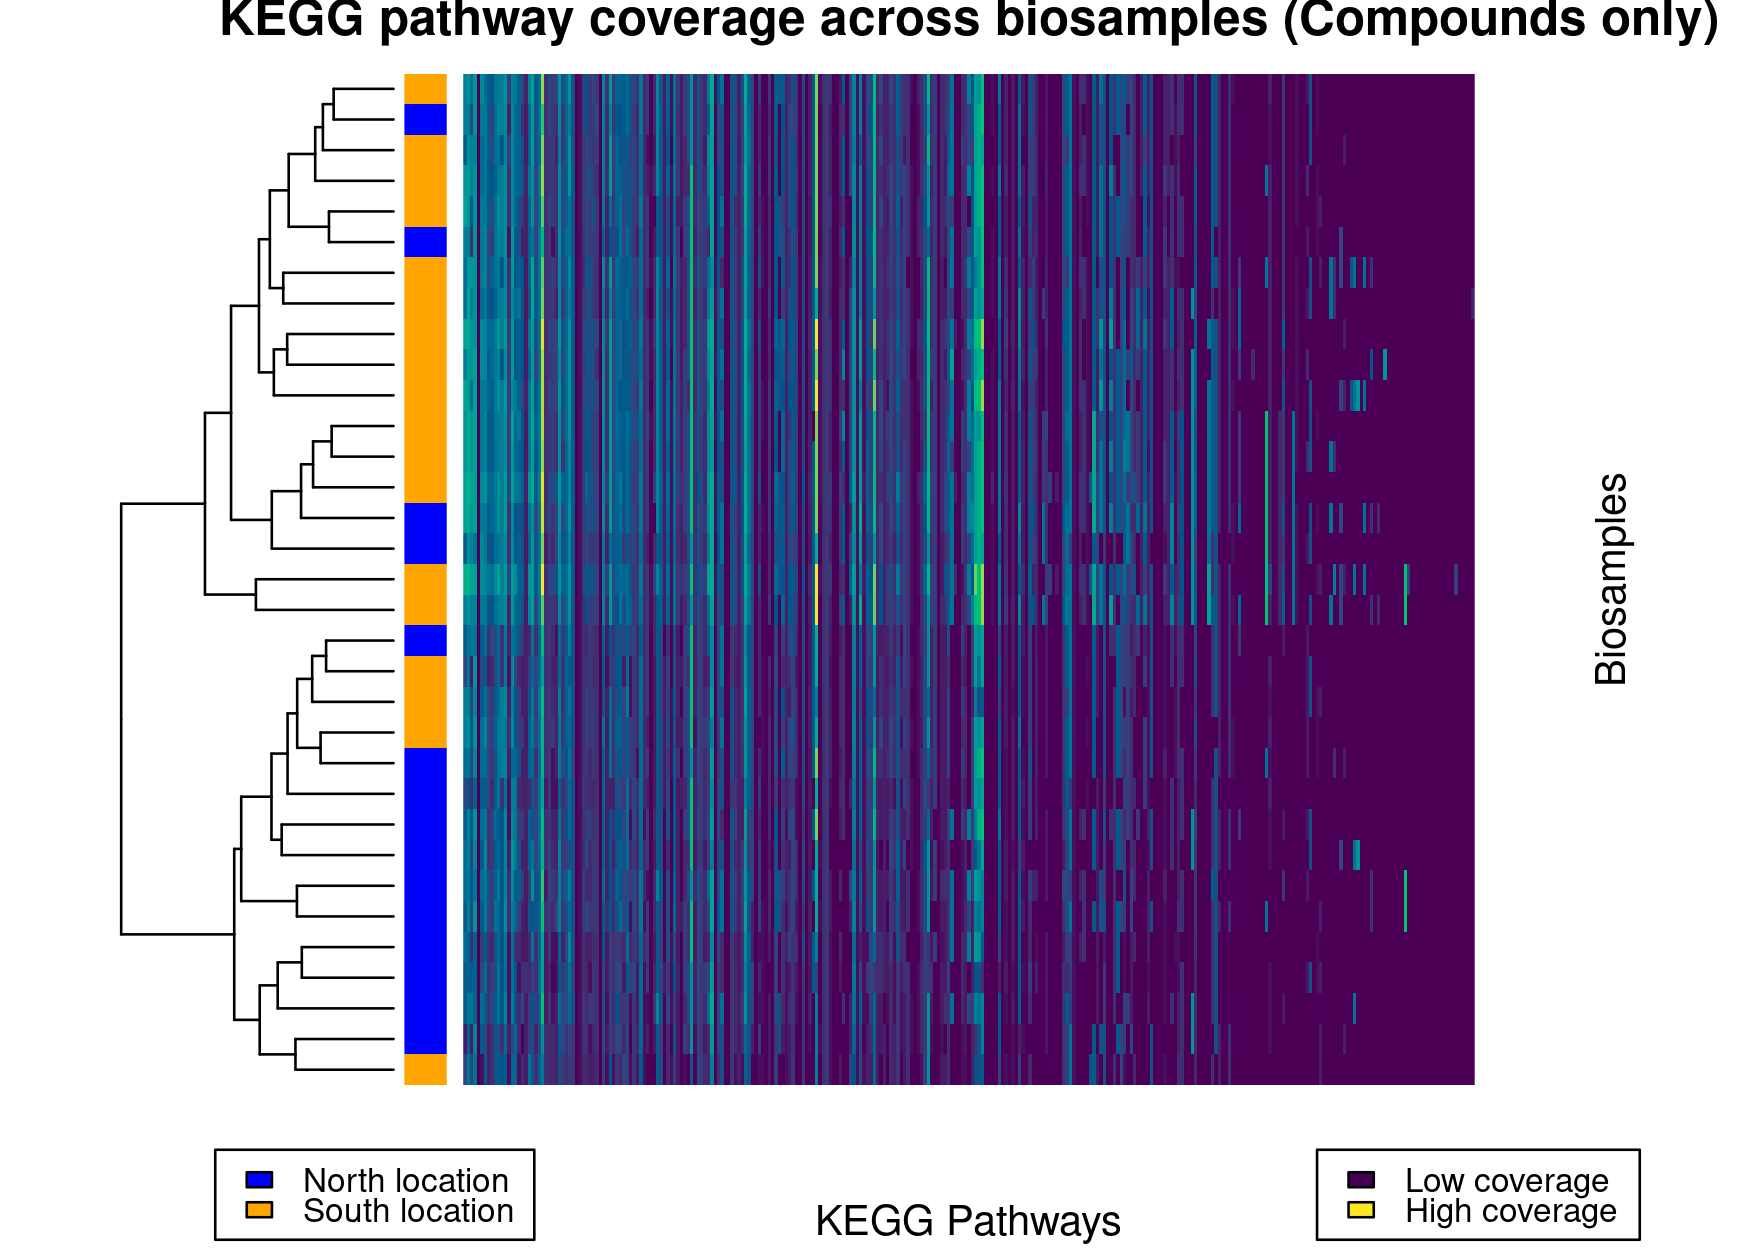

In [87]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 250)
par(xpd = TRUE)

pathway_coverage_by_biosample %>%
  bind_rows(.id = "biosample") %>%
  select(biosample, pathway_id, compound_coverage) %>%
  pivot_wider(names_from = "pathway_id", values_from = "compound_coverage") %>%
  replace(is.na(.), 0) %>%
  column_to_rownames(var = "biosample") %>%
  as.matrix() %>%
  
  heatmap(Colv = NA, RowSideColors = sample_color_vec,
          labRow = FALSE, labCol = FALSE, scale = "none",
          main = "KEGG pathway coverage across biosamples (Compounds only)",
          xlab = "KEGG Pathways",
          ylab = "Biosamples", 
          keep.dendro = FALSE, na.rm= TRUE,
          col = hcl.colors(50))

par(cex = 0.8)

legend(x = "bottomright", legend = c("Low coverage", "High coverage"), fill = c("#440154", "#FDE725"), inset = c(0, -0.2))

legend(x = "bottomleft", legend = c("North location", "South location"), fill = c("blue", "orange"), inset = c(0, -0.2))

The compound-only coverage dataframe shows the most clustering of samples by the sampling area.

### Highest coverage pathways
Next, try looking at trends across all the samples, such as the pathways with the highest average coverage. The cell below prints pathways that had over 50% coverage in any sample, ordered by average coverage.

In [27]:
pathway_coverage_by_biosample %>%
  bind_rows(.id = "biosample") %>%
  select(biosample, pathway_id, total_coverage) %>%
  group_by(pathway_id) %>%
  filter(any(total_coverage > 0.5)) %>%
  mutate(average_coverage = mean(total_coverage)) %>%
  ungroup() %>%
  arrange(-average_coverage) %>%
  pull(pathway_id) %>%
  unique()

[1] "path:map00571" "path:map00710" "path:map00020" "path:map00220"
[5] "path:map00770" "path:map00250" "path:map00260" "path:map04122"
[9] "path:map00010"

We can use the KEGG pathway documentation to find some more human-readable information for each of these pathway IDs. The pathways are grouped into categories. See the table of contents at https://www.genome.jp/kegg/pathway.html.

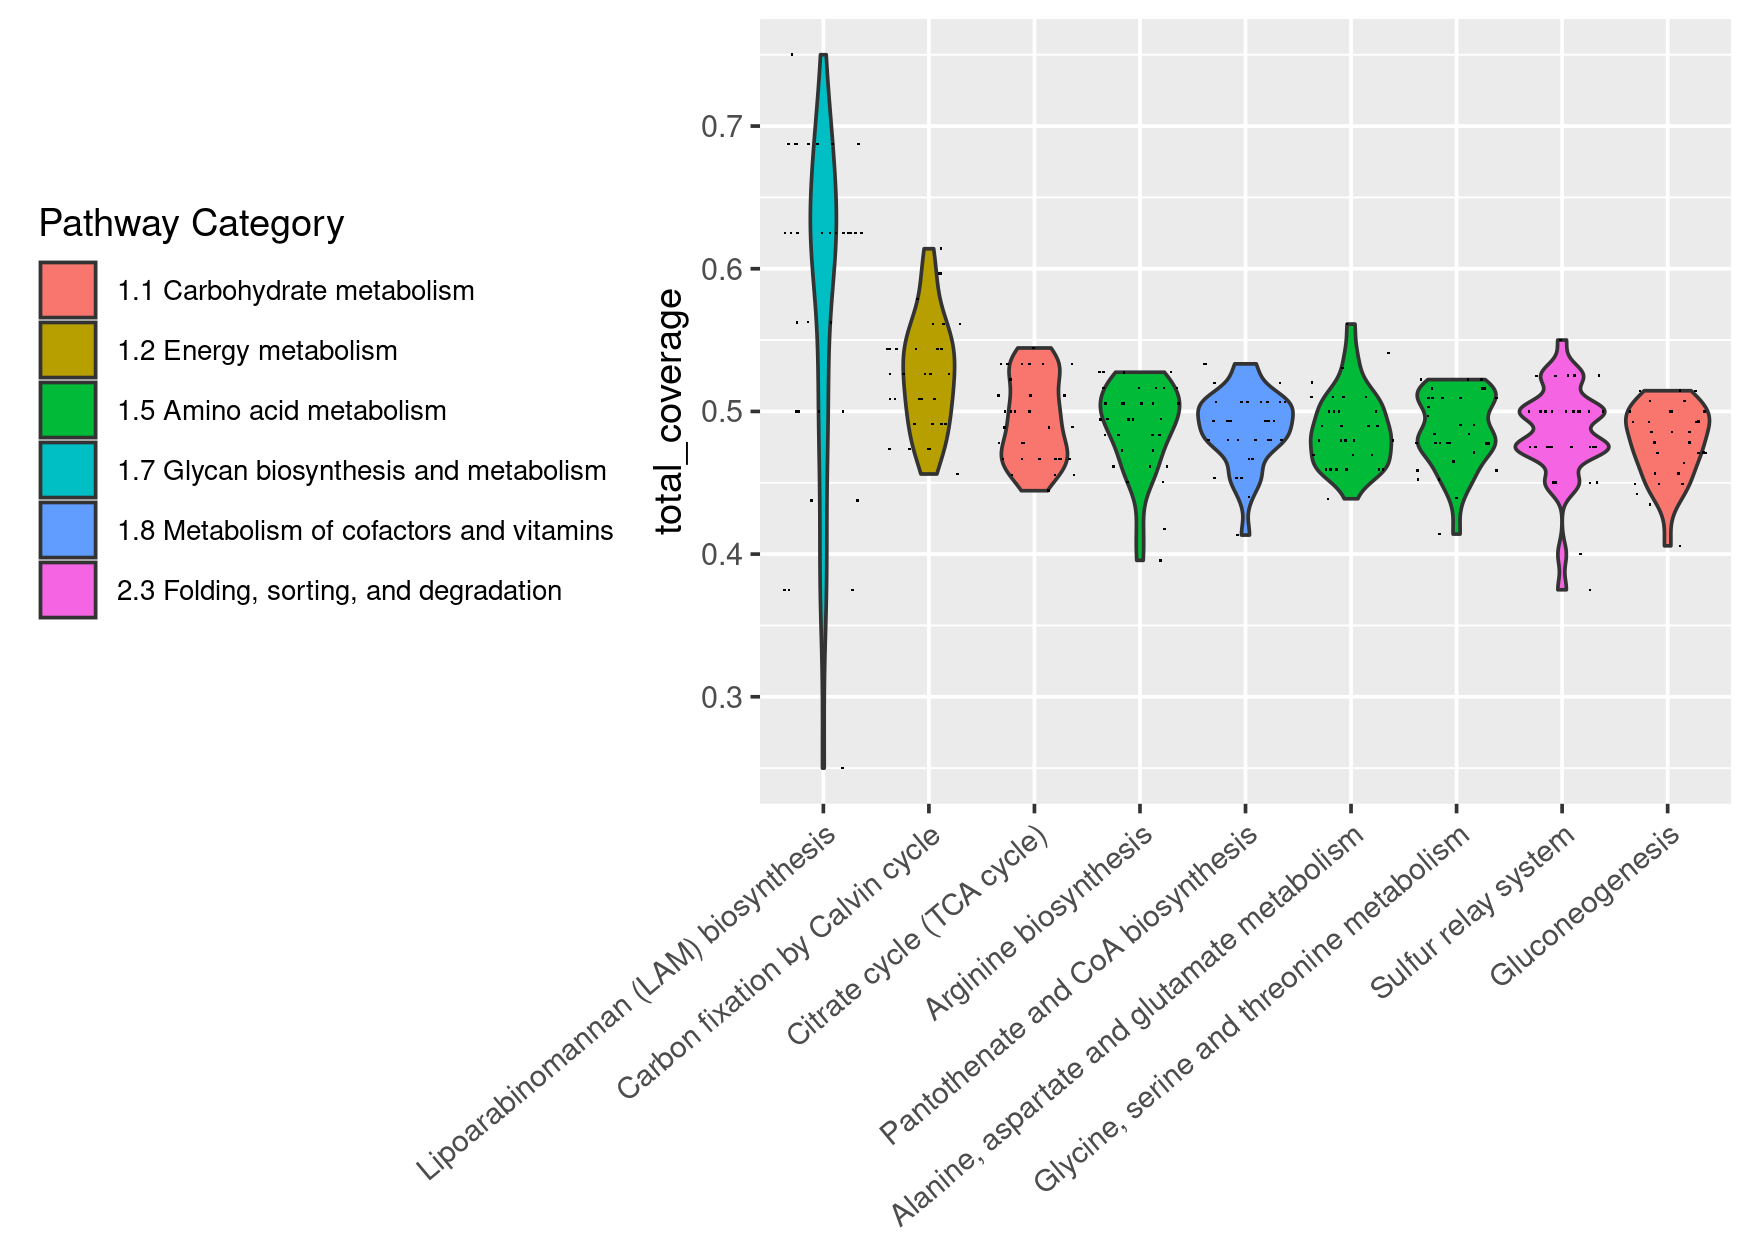

In [ ]:
# Create better labelling for plot
top_pathways <- data.frame(
  pathway_id = c("path:map00571", "path:map00710", "path:map00020", "path:map00220", "path:map00770",
                 "path:map00250", "path:map00260", "path:map04122", "path:map00010"),
  pathway_category = c("1.7 Glycan biosynthesis and metabolism", "1.2 Energy metabolism",
                       "1.1 Carbohydrate metabolism", "1.5 Amino acid metabolism", 
                       "1.8 Metabolism of cofactors and vitamins", "1.5 Amino acid metabolism",
                       "1.5 Amino acid metabolism", "2.3 Folding, sorting, and degradation",
                       "1.1 Carbohydrate metabolism"),
  pathway_name = c("Lipoarabinomannan (LAM) biosynthesis", "Carbon fixation by Calvin cycle", 
                   "Citrate cycle (TCA cycle)", "Arginine biosynthesis", "Pantothenate and CoA biosynthesis",
                   "Alanine, aspartate and glutamate metabolism", "Glycine, serine and threonine metabolism",
                   "Sulfur relay system", "Gluconeogenesis"))


pathway_coverage_by_biosample %>%
  bind_rows(.id = "biosample") %>%
  select(biosample, pathway_id, total_coverage) %>%
  group_by(pathway_id) %>%
  filter(any(total_coverage > 0.5)) %>%
  mutate(average_coverage = mean(total_coverage)) %>%
  ungroup() %>%
  arrange(-average_coverage) %>%
  left_join(top_pathways, by = join_by(pathway_id)) %>%
  mutate(pathway_name = factor(pathway_name, levels = unique(pathway_name))) %>%
  
  ggplot() +
    geom_violin(aes(x = pathway_name, y = total_coverage, fill = pathway_category)) +
    geom_jitter(aes(x = pathway_name, y = total_coverage), shape = ".") +
    labs(fill = "Pathway Category") +
    theme(axis.text.x = element_text(angle = 40, vjust = 1, hjust=1),
          axis.title.x = element_blank(),
          legend.position = "left",
          legend.text = element_text(size = 8))

## 7. Investigate an example KEGG pathway

The second highest coverage pathway in the plot above represents the Calvin cycle, an important process for many photosynthetic organisms. More information about this pathway can be found here: https://www.genome.jp/entry/map00710

Let's calculate in how many samples each pathway element was detected.

In [ ]:
# Select a pathway ID
pathway_detail_id <- "path:map00710"

# Create a vector of KO and compound IDs for the selected pathway, using the query results from earlier
pathway_detail_elements <- c(
  all_pathway_elements[which(all_pathway_elements$pathway_id == pathway_detail_id), 2],
  all_pathway_elements[which(all_pathway_elements$pathway_id == pathway_detail_id), 3]) %>% 
  unlist(use.names = FALSE)

# Pull out pathway elements for each sample
pathway_detail_identifications <- vector(mode = "list", length = nrow(results_by_biosample))

for (biosample in 1:length(pathway_detail_identifications)) {
  
  all_detections <- unique(c(gene_annotations_list[[biosample]]$ko_id,
                             protein_annotations_list[[biosample]]$ko_id,
                             metabolite_annotations_list[[biosample]]$compound_id))
  
  pathway_detail_identifications[[biosample]] <- data.frame(
    biomolecules = all_detections[toupper(all_detections) %in% toupper(pathway_detail_elements)])
}

# Count how many samples each pathway biomolecule appeared in
pathway_detail_identifications <- pathway_detail_identifications %>%
  bind_rows(.id = "biosample") %>%
  group_by(biomolecules) %>%
  summarize(sample_frequency = n()) %>% 
  ungroup() %>%
  # Calculate proportion of samples where the molecule was identified
  mutate(sample_frequency = sample_frequency/length(pathway_detail_identifications)) %>%
  # Clean up biomolecule ID format for pathview (below)
  mutate(biomolecules = str_match(biomolecules, ":(.+)$")[,2])

pathway_detail_identifications <- pull(pathway_detail_identifications) %>%
  setNames(pathway_detail_identifications$biomolecules)  

We can now use the `pathview` package to generate a colored version of the KEGG pathway diagram. The call to `pathview()` takes named vectors of genes and compounds separately and will apply the given color scale to the numeric values in the vector. This is intended for expression data but here the numeric values being represented are the proportion of samples where the biomolecule was identified across our omics data.

We can see that most of the rectangles on the map (KEGG renders them with EC numbers, but they each also correspond to a KO record) are highlighted in pink, showing that we found those genes in most of the samples. Most of the compounds identified were found in around half of the samples.

In [25]:
## TODO update this URL to main after merging
if(Sys.getenv("COLAB_BACKEND_VERSION") != "") download.file(url = "https://github.com/microbiomedata/nmdc_notebooks/blob/91-create-notebook-integrating-metag-metap-metab-data-r/omics_types_integration/R/ko00710.pathview.png")


![KEGG pathway map with genes/compounds colored by sample appearance](ko00710.pathview.png)


The code below, when uncommented, will generate the colored diagram and save it to the working directory.

In [26]:
# Save a colored KEGG pathway map to the working folder
# pathview(
#   gene.data = pathway_detail_identifications[which(str_detect(names(pathway_detail_identifications), "K"))],
#   cpd.data = pathway_detail_identifications[which(str_detect(names(pathway_detail_identifications), "C"))],
#   pathway.id = str_match(pathway_detail_id, ":map(.+)$")[,2],
#   species = "ko",
#   kegg.native = TRUE,
#   same.layer = TRUE,
#   limit = list(gene = c(0, 1), cpd = c(0, 1)),
#   bins = 14,
#   low=list(gene="cadetblue"),
#   mid = list(gene = "goldenrod"),
#   high=list(gene="palevioletred"),
#   key.align = "y"
# )

## Licensing Information

This notebook uses the KEGGREST and pathview R packages to interface with the KEGG API. Use of the KEGG API is restricted to academic users. Non-academic users must obtain a commercial license. (See https://www.kegg.jp/kegg/legal.html) The National Microbiome Data Collaborative use of KEGG is covered by license (license information).

//### TODO get license info

## Package Citations

Gu Z, Gu L, Eils R, Schlesner M, Brors B (2014). “circlize implements and enhances circular visualization in R.” Bioinformatics, 30, 2811-2812.

Luo, Weijun, Brouwer, Cory (2013). “Pathview: an R/Bioconductor package for pathway-based data integration and visualization.” Bioinformatics, 29(14), 1830-1831. doi:10.1093/bioinformatics/btt285.

Tenenbaum D, Maintainer B (2024). KEGGREST: Client-side REST access to the Kyoto Encyclopedia of Genes and Genomes (KEGG). R package version 1.46.0, https://bioconductor.org/packages/KEGGREST.
